# MODELO DE REGRESIÓN LOGÍSTICA

librerías necesarias para la implementación del modelo de regresión logística y la visualización de los resultados obtenidos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, recall_score, classification_report, accuracy_score, roc_curve, auc


Carga de los archivos train y test y visualización del conjunto de prueba.

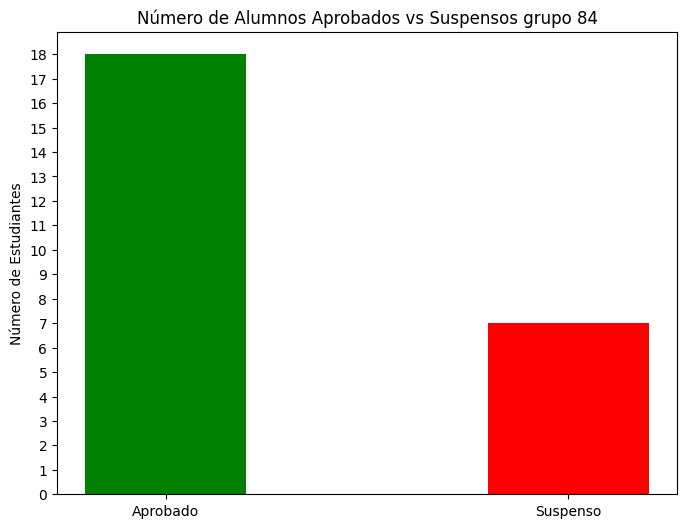

In [2]:
#Carga de los archivos para train y test. Utilizaré los datos de las clases 96, 89 y 81 para entrenar el modelo y para probar el modelo utilizaré los datos de la clase 84
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test.xlsx')

#Visualización de los datos del dataset "test"
#Primero se cuentan los alumnos aprobados y los alumnos suspensos
aprobados = test_data[test_data['nota_final_aprobado'] == 'SI'].shape[0]
suspensos = test_data[test_data['nota_final_aprobado'] == 'NO'].shape[0]

#Creación del gráfico de barras para la visualización de los datos
plt.figure(figsize=(8, 6))
max_value = max(aprobados, suspensos)
plt.yticks(range(0, max_value + 1))
plt.bar('Aprobado', aprobados, width=0.4, color='green')
plt.bar('Suspenso', suspensos, width=0.4, color='red')
plt.title('Número de Alumnos Aprobados vs Suspensos grupo 84')
plt.ylabel('Número de Estudiantes')
plt.show()


In [3]:
#Visualización de los datos
train_data.head()

,login_est,created,submitted,uploaded,viewed,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,diferencia_dias_week1,diferencia_dias_week2,diferencia_dias_week3,accesos_week1,accesos_week2,accesos_week3,wooclap_average,nota_final_aprobado
0,1,0,0,0,71,4,22,17,16,8,2,2,-1,-1,-1,4,20,6,100.0,NO
1,2,0,0,0,32,0,13,4,2,5,6,2,-1,-1,-1,4,8,4,100.0,SI
2,3,3,3,3,136,3,16,22,69,35,0,0,2,6,1,3,10,6,87.5,SI
3,4,3,3,3,122,0,8,1,34,21,27,40,5,5,3,2,1,1,77.5,SI
4,5,4,3,4,227,5,54,21,89,52,6,11,6,5,3,5,5,5,87.5,SI


In [4]:
#Se definen las variables independientes X de la variable objetivo Y que será la variable 'nota_final_aprobado' de cada dataframe
#Primero se tiene que transformar las etiquetas categóricas de la variable independiente a forma numérica. En este caso utilizamos LabelEnconder() que transformará
#en enteros los valores SI y NO por los valores 1 y 0
encoder = LabelEncoder()
train_data['nota_final_aprobado'] = encoder.fit_transform(train_data['nota_final_aprobado'])
test_data['nota_final_aprobado'] = encoder.transform(test_data['nota_final_aprobado'])
X_train = train_data.drop('nota_final_aprobado', axis=1)
y_train = train_data['nota_final_aprobado']
X_test = test_data.drop('nota_final_aprobado', axis=1)
y_test = test_data['nota_final_aprobado']

#Se normalizan los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Se definen las diferentes configuraciones de la variable 'class_weights' para la ejecución de la validación cruzada
class_weights = [None, 'balanced', {0: 2, 1: 1}, {0: 3, 1: 1}]

#Se crea un scorer que usa el f1-score para medir el desempeño del modelo utilizando la validación cruzada.
scorer = make_scorer(f1_score)

#Se ejecuta la validacion cruzada con los diferentes class_weight para evaluar qué ponderación es más consistente
results = []
for cw in class_weights:
    model = LogisticRegression(class_weight=cw, max_iter=3000)
    cv_results = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scorer)
    results.append(cv_results['test_score'])

results

[array([0.80952381, 0.81818182, 0.7804878 , 0.76923077, 0.80952381]),
 array([0.5       , 0.74285714, 0.66666667, 0.55172414, 0.8       ]),
 array([0.625     , 0.75675676, 0.77777778, 0.55172414, 0.78947368]),
 array([0.46153846, 0.64285714, 0.51851852, 0.56      , 0.70967742])]

CROSS-VALIDATION CON DIFERENTES CONFIGURACIONES

Como se puede ver en la validación cruzada del apartado anterior, he definido 4 diferentes configuraciones para la clase:

1.  None: no utiliza ninguna ponderación de clase, por lo que todos los casos en conjunto de datos tienen  la misma importancia durante el entrenamiento del modelo, sin importar la frecuencia de su clase.
2.  'balanced': para esta configuración de clase balanceada, scikit-learn ajusta los pesos de las clases automaticamente dependiendo de la frecuencia de las clases usando la fórmula: n_samples / (n_classes * np.bincount(y)), por lo que las clases con menos muestras reciben un mayor peso durante el entrenamiento del modelo.
3.  {0: 2, 1: 1}: en esta configuración he utilizado el diccionario {0: 2, 1: 1} para especificar un peso diferente para cada clase durante el entrenamiento del modelo. Esto modifica la función de pérdida del modelo para que se penalice más o menos la clasificación incorrecta de ciertas clases, dependiendo de los pesos que se les asignen. En este caso:
        -   Clase 0: se le asigna el peso de 2, lo que significa que los errores en la clasificación de instancias de la clase 0 tienen un impacto 2 veces mayor que en la clase 1. 
        -   Clase 1: se le asigna el peso de 1, que es el peso estándar, no modificando la función de pérdida.
4.  {0: 3, 1: 1}: en esta configuración he utilizado el diccionario {0: 3, 1: 1} para especificar un peso diferente para cada clase durante el entrenamiento del modelo. Esto modifica la función de pérdida del modelo para que se penalice más o menos la clasificación incorrecta de ciertas clases, dependiendo de los pesos que se les asignen. En este caso:
        -   Clase 0: se le asigna el peso de 3, lo que significa que los errores en la clasificación de instancias de la clase 0 tienen un impacto 3 veces mayor que en la clase 1. 
        -   Clase 1: se le asigna el peso de 1, que es el peso estándar, no modificando la función de pérdida.

Entrenamiento, evaluación y resultados del modelo de regresión logística.

In [5]:
#Se entrena el modelo con la ponderación de clase {0: 2, 1: 1} y evaluamos el modelo en el conjunto de prueba
cw = {0: 2, 1: 1}
model = LogisticRegression(class_weight=cw, max_iter=12,random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

#Se imprime en pantalla el f1-score, accuracy, recall y el classification report
accuracy = accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=False)
print("Accuracy:", accuracy)
print("F1-Score:", score)
print("Recall:", recall)
print("Classification Report\n", class_report)

Accuracy: 0.8
F1-Score: 0.8571428571428571
Recall: 0.8333333333333334
Classification Report
               precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.88      0.83      0.86        18

    accuracy                           0.80        25
   macro avg       0.75      0.77      0.76        25
weighted avg       0.81      0.80      0.80        25



Visualización y cálculo de la curva ROC del modelo de regresión logística.

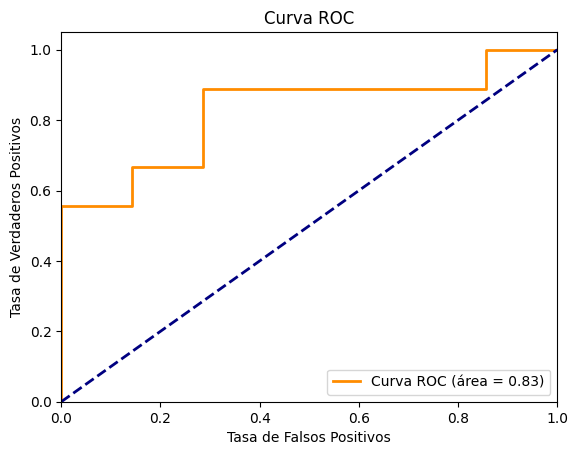

In [6]:
#Se calculan las probabilidades de la curva ROC para calcular la curva ROC y el AUC
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

#Se crea y muestra la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Visualización de la matriz de confusión con los resultados obtenidos con las predicciones del modelo de regresión logística.

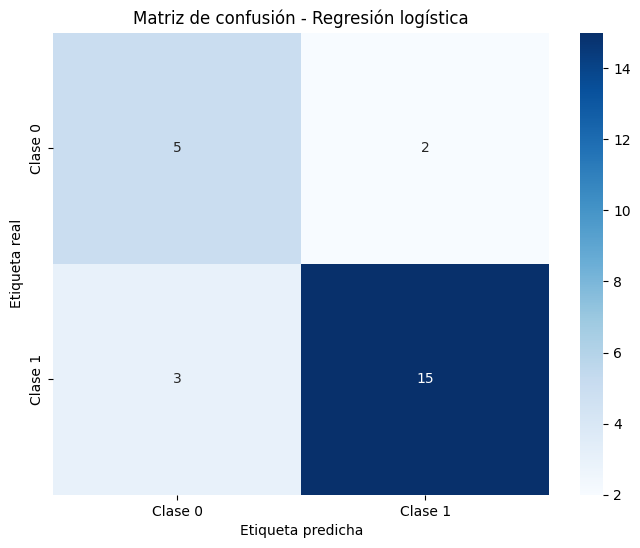

In [7]:
#Se crea la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión - Regresión logística')
plt.show()

Se visualiza la comparación entre los valores reales y las predicciones del modelo de regresión logística.

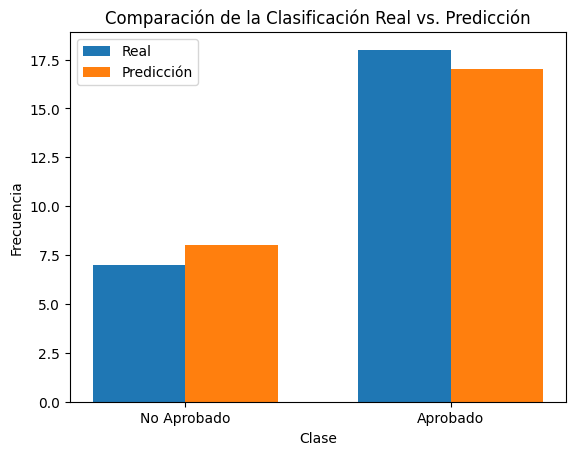

In [8]:
#Se calcula las frecuencias de las clases en los datos reales y predichos
conteo_reales = np.bincount(y_test)
conteo_predichas = np.bincount(y_pred)

#Se asegura que los vectores tienen la misma longitud
max_length = max(len(conteo_reales), len(conteo_predichas))
conteo_reales = np.pad(conteo_reales, (0, max_length - len(conteo_reales)), 'constant')
conteo_predichas = np.pad(conteo_predichas, (0, max_length - len(conteo_predichas)), 'constant')
etiquetas = ['No Aprobado', 'Aprobado']

#Creación del diagrama de barras para la visualización de los datos
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(etiquetas))
bar1 = ax.bar(index, conteo_reales, bar_width, label='Real')
bar2 = ax.bar(index + bar_width, conteo_predichas, bar_width, label='Predicción')
ax.set_xlabel('Clase')
ax.set_ylabel('Frecuencia')
ax.set_title('Comparación de la Clasificación Real vs. Predicción')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(etiquetas)
ax.legend()

plt.show()

Comparación 1 a 1 de los resultados reales con los resultados predichos.

In [9]:
#Comparación de y_test y y_pred
comparacion = pd.concat([y_test, pd.Series(y_pred)], axis = 1)
comparacion.rename(columns={'nota_final_aprobado':'y_test', 0:'y_pred'}, inplace=True)
comparacion

,y_test,y_pred
0,0,0
1,1,1
2,1,1
3,0,1
4,0,0
5,1,0
6,0,0
7,0,1
8,0,0
9,1,1
